In [1]:
from cpg_fsm import *
from scipy.optimize import differential_evolution
from scipy.optimize import LinearConstraint, Bounds
from scipy.optimize import NonlinearConstraint
from scipy.optimize import minimize
import pickle

In [2]:
loop_freq = 100  # Hz

L = 0.2 # step_length
stanceHeight=0.2
T_sw = 0.4

H_upper = 0.05
H_lower = 0.03
C_s = 3
C_u = 0.5
px_init = L/4
mx_init = -L/4
cycle = 4*6
total_t = 30

dH_upper = 0.01
L1_lower = 0.05
L3_lower = 0.05

tb_1 = lk.InverseKinematicsPoly(np.array([[px_init], [-stanceHeight]]))
tb_2 = lk.InverseKinematicsPoly(np.array([[mx_init], [-stanceHeight]]))
init_A_tb = tb_1
init_B_tb = tb_1
init_C_tb = tb_2
init_D_tb = tb_2

FSM = FiniteStateMachine(loop_freq)
CORGI = Corgi(loop_freq, FSM)
CORGI.step_length = L
CORGI.stance_height = stanceHeight
CORGI.swing_time = T_sw
CORGI.weight_s = C_s
CORGI.weight_u = C_u
CORGI.total_cycle = 4
CORGI.total_time = total_t
CORGI.setInitPhase(init_A_tb, init_B_tb, init_C_tb, init_D_tb)
CORGI.move()

t = time.time()
iter = 0

cost -1.2413974822709748


In [3]:
bez_prof_init = np.array(
        [
            [0.10, 0.01, 0.15, 0.05, 0.08, 0.06],
            [0.10, 0.01, 0.15, 0.05, 0.08, 0.06],
            [0.10, 0.01, 0.08, 0.05, 0.02, 0.1],
            [0.10, 0.01, 0.08, 0.05, 0.02, 0.1],
        ]
    )

bez_prof_fail = np.array([0.1, 0.01, 0.4, 0.05, 0.08, 0.06])
bez_prof_fail = np.repeat(bez_prof_fail, repeats=4).reshape(6,4).transpose()

In [4]:
A_liftstate = CORGI.lift_state[0]
B_liftstate = CORGI.lift_state[2]
C_liftstate = CORGI.lift_state[1]
D_liftstate = CORGI.lift_state[3]
liftstates = [A_liftstate, B_liftstate, C_liftstate, D_liftstate]

def getBezierControlPoint(c0, bp):
    h, dh, dL1, dL2, dL3, dL4 = bp
    c0 = np.array([0, 0])
    c1 = c0 - np.array([dL1, 0])
    c2 = c1 - np.array([dL2, 0]) + np.array([0, h])
    c3 = c2
    c4 = c2
    c5 = c4 + np.array([0.5 * L + dL1 + dL2, 0])
    c6 = c5
    c7 = c5 + np.array([0, dh])
    c8 = c7 + np.array([0.5 * L + dL3 + dL4, 0])
    c9 = c8
    c10 = c8 - np.array([dL4, h + dh])
    c11 = c10 - np.array([dL3, 0])
    c_set = np.array([c0, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11])
    return c_set

def getBezierCurve(bezier_profile, L, point_num=20):
    h, dh, dL1, dL2, dL3, dL4 = bezier_profile
    c_set = getBezierControlPoint(np.array([0,0]), bezier_profile)
    t_points = np.linspace(0, 1, point_num)
    curve = Bezier.Curve(t_points, c_set)
    return curve

def workspaceConstraint(bezier_profiles, step_len, liftstates, cons_type="forehind", point_num=20, shrink_margin=0.01):
    bps = bezier_profiles.reshape(4, -1)
    t_ = np.linspace(0, 1, point_num).reshape(point_num, -1)
    subs = []

    for i in range(4):
        b_curve = getBezierCurve(bps[i], step_len, point_num)
        v_OG = liftstates[i][2].copy()
        if i == 0 or i == 3:
            v_OG[0, 0] *= -1
        hip1 = -1 * v_OG
        hip1s = np.repeat(hip1.T, repeats=point_num, axis=0)
        hip_t = hip1s + t_@np.array([[L/4, 0]])

        dv = hip_t - b_curve
        d = np.linalg.norm(dv, axis=1).reshape(point_num, -1)
        if cons_type == "inner":
            # inner circle constraint d - (0.1 + shrink_margin) >0
            r_ = (0.1+shrink_margin) * np.ones([point_num, 1])
            subs.append(d-r_)
        elif cons_type == "outer":
            # outer circle constraint (0.3428 - shrink_margin) - d >0
            r_ = (0.3428-shrink_margin) * np.ones([point_num, 1])
            subs.append(r_-d)
        elif cons_type == "forehind":
            # print(center_line_x)
            # print("--")
            if i == 0 or i == 1:
                # PointG_x >= center_line_x + margin --> PointG_x - (center_line_x + margin) >= 0
                center_line_x = hip_t[:, 0].reshape(point_num, -1) - 0.222*np.ones([point_num,1]) + shrink_margin*np.ones([point_num, 1])
                b_curve_x = b_curve[:, 0].reshape(point_num, -1)
                subs.append(b_curve_x - center_line_x)
            else:
                center_line_x = hip_t[:, 0].reshape(point_num, -1) + 0.222*np.ones([point_num,1]) - shrink_margin*np.ones([point_num, 1])
                b_curve_x = b_curve[:, 0].reshape(point_num, -1)
                subs.append(center_line_x - b_curve_x)
    cons = np.vstack((subs[0], subs[1]))
    cons = np.vstack((cons, subs[2]))
    cons = np.vstack((cons, subs[3]))
    cons = cons.reshape(1, -1)[0]
    # cons >= 0 to fit the constraint
    return cons

def BezierProfileConstraint(bezier_profiles):
    bps = bezier_profiles.reshape(4,-1)
    cons = []
    for i in range(4):
        cset = getBezierControlPoint(np.array([0,0]), bps[i])
        c2_x = cset[2,0]
        c5_x = cset[5,0]
        c8_x = cset[8,0]
        # c2_x < c5_x, c8_x > c5_x
        cons.append(c5_x-c2_x)
        cons.append(c8_x-c5_x)
    return np.array(cons)

def velocityConstraint(bezier_profiles, step_len, T_sw, point_num=40, vx_tol=0.005, vy_tol=0.005):
    bps = bezier_profiles.reshape(4,-1)
    cons = []
    dt = T_sw/point_num
    v_stance = np.array([-(step_len/4)/T_sw, 0])
    cons = []
    for i in range(4):
        b_curve = getBezierCurve(bps[i], step_len, point_num)
        v_liftoff = (b_curve[1] - b_curve[0])/dt
        v_landing = (b_curve[-1] - b_curve[-2])/dt

        dv_liftoff = v_liftoff - v_stance
        dv_landing = v_landing - v_stance
        cons.append(dv_liftoff)
        cons.append(dv_landing)
        # print(b_curve)
        # print(np.diff(b_curve, axis=0))        
    return np.array(cons).reshape(1,-1)[0]


# print(workspaceConstraint(bez_prof_init, L, liftstates, point_num = 10))
# print(BezierProfileConstraint(bez_prof_init))
print(velocityConstraint(bez_prof_init, L, T_sw))

[-3.75791358  0.31005373 -2.04634813 -0.3410546  -3.75791358  0.31005373
 -2.04634813 -0.3410546  -2.01820162  0.31005373 -0.67940782 -0.3410546
 -2.01820162  0.31005373 -0.67940782 -0.3410546 ]


In [5]:
def getTrajectoryCost(bezier_profiles):
    global iter
    global t
    print("t", time.time()-t)
    
    t = time.time()
    bp = bezier_profiles.reshape(4, -1)
    tb_1 = lk.InverseKinematicsPoly(np.array([[px_init], [-stanceHeight]]))
    tb_2 = lk.InverseKinematicsPoly(np.array([[mx_init], [-stanceHeight]]))
    init_A_tb = tb_1
    init_B_tb = tb_1
    init_C_tb = tb_2
    init_D_tb = tb_2

    FSM = FiniteStateMachine(loop_freq)
    CORGI = Corgi(loop_freq, FSM)
    CORGI.stance_height = stanceHeight
    CORGI.total_cycle = 4
    CORGI.step_length = L
    CORGI.swing_time = T_sw
    CORGI.weight_s = C_s
    CORGI.weight_u = C_u
    CORGI.setInitPhase(init_A_tb, init_B_tb, init_C_tb, init_D_tb)
    CORGI.move(swing_profile=bp)
    
    print("iter", iter,"cost",CORGI.cost)
    iter += 1
    return CORGI.cost

In [6]:
bnd_H = (H_lower, H_upper)
bnd_dH = (0, dH_upper)
f_bnd_L1 = (L1_lower, 1)
f_bnd_L2 = (-0.05, 0.05)
f_bnd_L3 = (L3_lower, 1)
f_bnd_L4 = (-0.05, 0.05)

h_bnd_L1 = (L1_lower, 1)
h_bnd_L2 = (-0.05, 0.05)
h_bnd_L3 = (L3_lower, 1)
h_bnd_L4 = (-0.05, 0.05)

bez_prof_init = np.array([[0.06, 0.01, 0.03, 0.01, 0.03, 0.01],
                          [0.06, 0.01, 0.03, 0.01, 0.03, 0.01],
                          [0.06, 0.01, 0.03, 0.01, 0.03, 0.01],
                          [0.06, 0.01, 0.03, 0.01, 0.03, 0.01]])

bez_prof_init = bez_prof_init.reshape(1, -1)[0]

innerCons = {'type': 'ineq', 'fun':workspaceConstraint, 'args':(L, liftstates, "inner", 20, 0.02)}
outerCons = {'type': 'ineq', 'fun':workspaceConstraint, 'args':(L, liftstates, "outer", 20, 0.02)}
centerlineCons = {'type': 'ineq', 'fun':workspaceConstraint, 'args':(L, liftstates, "forehind", 20, 0.02)}
bezCons = {'type': 'ineq', 'fun':BezierProfileConstraint}
velCons = {'type': 'eq', 'fun':velocityConstraint, 'args':(L, T_sw)}

Cons = [innerCons, outerCons, centerlineCons, bezCons, velCons]

# NonlinearConstraint(workspaceConstraint, -np.inf*np.ones(24,1))


In [7]:
# h, dh, dL1, dL2, dL3, dL4 = bezier_profile
bnds = [bnd_H, bnd_dH, f_bnd_L1, f_bnd_L2, f_bnd_L3, f_bnd_L4,
        bnd_H, bnd_dH, f_bnd_L1, f_bnd_L2, f_bnd_L3, f_bnd_L4,
        bnd_H, bnd_dH, h_bnd_L1, h_bnd_L2, h_bnd_L3, h_bnd_L4,
        bnd_H, bnd_dH, h_bnd_L1, h_bnd_L2, h_bnd_L3, h_bnd_L4]
# result = differential_evolution(getTrajectoryCost, bounds=bnds, recombination=0.5, constraints=Cons, seed=1, workers=-1)
# min_ = minimize(getTrajectoryCost, bez_prof_init, method='Nelder-Mead',bounds=bnd, constraints=Cons,\
#                  options={'disp': True, 'maxiter': 800, "adaptive": True})
# min_ = minimize(getTrajectoryCost, bez_prof_init, bounds=bnd, constraints=[constraint], \
#         options={"maxiter": 200})


min_ = minimize(getTrajectoryCost, bez_prof_init, method='SLSQP', bounds=bnds,tol=0.001, constraints=Cons,\
         options={'disp': True, 'maxiter':100})

t 0.16874408721923828
cost -1.3986961157382478
iter 0 cost -1.3986961157382478
t 0.1613161563873291
cost -1.3986961058683782
iter 1 cost -1.3986961058683782
t 0.14964866638183594
cost -1.3986961157945728
iter 2 cost -1.3986961157945728
t 0.15429115295410156
cost -1.3986960988889368
iter 3 cost -1.3986960988889368
t 0.16020655632019043
cost -1.3986961116802137
iter 4 cost -1.3986961116802137
t 0.1472916603088379
cost -1.398696106274668
iter 5 cost -1.398696106274668
t 0.15048909187316895
cost -1.3986961153509623
iter 6 cost -1.3986961153509623
t 0.15749740600585938
cost -1.3986961227040817
iter 7 cost -1.3986961227040817
t 0.17103815078735352
cost -1.3986961169572452
iter 8 cost -1.3986961169572452
t 0.14836335182189941
cost -1.3986961225628425
iter 9 cost -1.3986961225628425
t 0.19229578971862793
cost -1.3986961180910018
iter 10 cost -1.3986961180910018
t 0.15514159202575684
cost -1.3986961094129156
iter 11 cost -1.3986961094129156
t 0.15118646621704102
cost -1.3986961155466568
iter 12

Optimized Bezier Profile:
[[ 0.04192069  0.00838414  0.05001634 -0.05        0.05       -0.05      ]
 [ 0.04192069  0.00838414  0.05       -0.04986901  0.05       -0.05      ]
 [ 0.04192069  0.00838414  0.05       -0.04986901  0.05       -0.05      ]
 [ 0.04192069  0.00838414  0.05       -0.04986901  0.05       -0.05      ]]


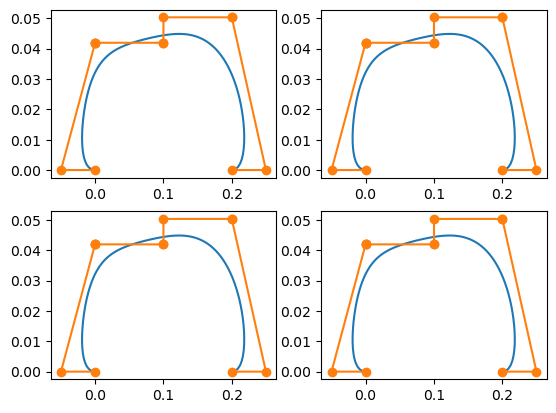

In [8]:
opt_bez = min_.x
opt_bez = opt_bez.reshape(4,-1)
print("Optimized Bezier Profile:")
print(opt_bez)

fig, ax = plt.subplots(2,2)
A_curve = getBezierCurve(opt_bez[0], L, 100)
B_curve = getBezierCurve(opt_bez[1], L, 100)
C_curve = getBezierCurve(opt_bez[2], L, 100)
D_curve = getBezierCurve(opt_bez[3], L, 100)
A_cset = getBezierControlPoint(np.array([0,0]), opt_bez[0])
B_cset = getBezierControlPoint(np.array([0,0]), opt_bez[1])
C_cset = getBezierControlPoint(np.array([0,0]), opt_bez[2])
D_cset = getBezierControlPoint(np.array([0,0]), opt_bez[3])
ax[0][0].plot(A_curve[:,0], A_curve[:,1])
ax[0][0].plot(A_cset[:,0], A_cset[:,1], "-o")

ax[0][1].plot(B_curve[:,0], B_curve[:,1])
ax[0][1].plot(B_cset[:,0], B_cset[:,1], "-o")

ax[1][0].plot(C_curve[:,0], C_curve[:,1])
ax[1][0].plot(C_cset[:,0], C_cset[:,1], "-o")

ax[1][1].plot(D_curve[:,0], D_curve[:,1])
ax[1][1].plot(D_cset[:,0], D_cset[:,1], "-o")
plt.show()


In [12]:
# Save Parameters and export Trajectory
import datetime

sbrio_filename = str(datetime.date.today()) + "_traj_400_1.csv"
param_filename = str(datetime.date.today()) + "_param_400_1.csv"
csv_filepath = "./csv_trajectory/20230827/" + sbrio_filename
webot_filepath = "/home/guanlunlu/corgi_webots/controllers/supervisor/" + sbrio_filename
param_filepath = "./csv_trajectory/20230827/" + param_filename

with open(str(datetime.date.today()) + "_param_400_1.pkl", 'wb') as f:
    pickle.dump(min_, f)

with open(param_filepath, 'w') as f:
    f.write("loop_freq,"+str(loop_freq)+"\n")
    f.write("Step_length,"+str(L)+"\n")
    f.write("swing_time,"+str(T_sw)+"\n")
    f.write("C_s,"+str(C_s)+"\n")
    f.write("C_u,"+str(C_u)+"\n")
    f.write("px_init,"+str(px_init)+"\n")
    f.write("mx_init,"+str(mx_init)+"\n")
    f.write("cycle,"+str(cycle)+"\n")
    f.write("total_t,"+str(total_t)+"\n")
    f.write("init_bezier_profile"+repr(bez_prof_init)+"\n")
    f.write("optimize_bezier_profile"+repr(min_.x)+"\n")
    f.write("\n")
    f.write(repr(min_))
    f.write('\n')

cycle = 20
# Export CSV for sbrio
sbrio_freq = 400
tb_1 = lk.InverseKinematicsPoly(np.array([[px_init], [-stanceHeight]]))
tb_2 = lk.InverseKinematicsPoly(np.array([[mx_init], [-stanceHeight]]))
init_A_tb = tb_1
init_B_tb = tb_1
init_C_tb = tb_2
init_D_tb = tb_2
FSM = FiniteStateMachine(sbrio_freq)
CORGI = Corgi(sbrio_freq, FSM)
CORGI.step_length = L
CORGI.stance_height = stanceHeight
CORGI.swing_time = T_sw
CORGI.weight_s = C_s
CORGI.weight_u = C_u
CORGI.total_cycle = cycle
CORGI.total_time = total_t
CORGI.setInitPhase(init_A_tb, init_B_tb, init_C_tb, init_D_tb)
CORGI.move(swing_profile=opt_bez)
CORGI.exportCSV(csv_filepath)
print("sbrio exported")

# Export CSV for webot
tb_1 = lk.InverseKinematicsPoly(np.array([[px_init], [-stanceHeight]]))
tb_2 = lk.InverseKinematicsPoly(np.array([[mx_init], [-stanceHeight]]))
init_A_tb = tb_1
init_B_tb = tb_1
init_C_tb = tb_2
init_D_tb = tb_2
FSM = FiniteStateMachine(40)
CORGI = Corgi(40, FSM)
CORGI.step_length = L
CORGI.stance_height = stanceHeight
CORGI.swing_time = T_sw
CORGI.weight_s = C_s
CORGI.weight_u = C_u
CORGI.total_cycle = cycle
CORGI.total_time = total_t
CORGI.setInitPhase(init_A_tb, init_B_tb, init_C_tb, init_D_tb)
CORGI.move(swing_profile=opt_bez)
CORGI.exportCSV(webot_filepath)
print("sbrio exported")

cost -6.369104880241129
sbrio exported
cost -15.599963045109892
sbrio exported
